In [4]:
import tensorflow.contrib.layers as lays

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [5]:
# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# 55,000 train samples
# 10,000 test samples
# 28×28 grayscale image

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
batchSize = 64  # Number of samples in each batch
lr = [0.1, 0.01, 0.001]  # Learning rate

In [7]:
# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batchSize

In [8]:
def autoencoder(inputs):
    # def encoder(inputs):
    net = lays.conv2d(inputs, 8, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 1   ->  28 x 28 x 8

    net = lays.conv2d(net, 4, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 4
    net = tf.layers.max_pooling2d(net, [2,2], 2)
    # 28 x 28 x 4   ->  14 x 14 x 4
    net = lays.conv2d(net, 2, [3, 3], stride=1, padding='SAME')
    # 14 x 14 x 4   ->  14 x 14 x 2
    net = tf.layers.max_pooling2d(net, [2,2], 2)
    # 14 x 14 x 4   ->  7 x 7 x 2

    # def decoder(net):
    net = lays.conv2d_transpose(net, 4, [2, 2], stride=2, padding='SAME')
    # 7 x 7 x 2   ->  14 x 14 x 4
    net = lays.conv2d(net, 4, [3, 3], stride=1, padding='SAME')
    # 14 x 14 x 4   ->  14 x 14 x 4
    net = lays.conv2d_transpose(net, 8, [2, 2], stride=2, padding='SAME')
    # 14 x 14 x 4   ->  28 x 28 x 8
    net = lays.conv2d(net, 8, [3, 3], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 8

    net = lays.conv2d(net, 1, [1, 1], stride=1, padding='SAME')
    # 28 x 28 x 8   ->  28 x 28 x 1
    return net

In [9]:
# calculate loss and cost, define optimizer
input_image_placeholder = tf.placeholder(tf.float32, (None, 28, 28, 1))  # input to the network (MNIST images)
network_output = autoencoder(input_image_placeholder)  # create the Autoencoder network

loss = tf.reduce_mean(tf.square(network_output - input_image_placeholder))

learning_rate_placeholder = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder).minimize(cost)

In [10]:
# initialize the network
init = tf.global_variables_initializer()

# save the costs for later ploting
costCurve = [[] for x in range(len(lr))]

Training the Autoencoder and creating reconstructed images

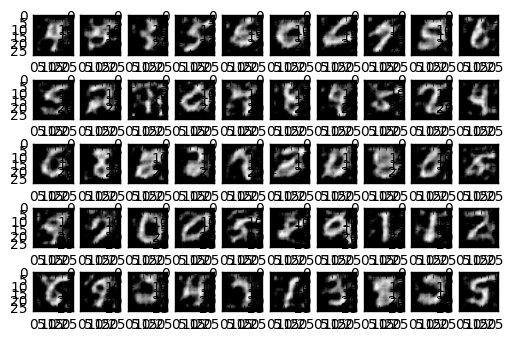

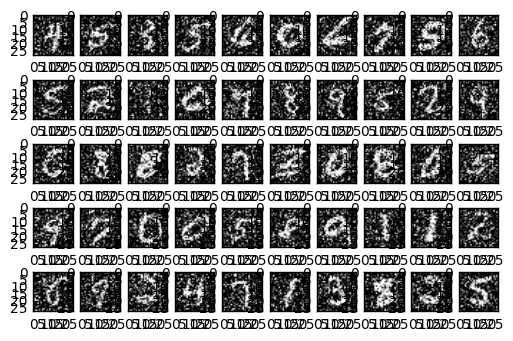

In [12]:
with tf.Session() as sess:
    for idx in range(len(lr)):  # epochs loop
        sess.run(init)
        for batch_n in range(batch_per_ep):  # batches loop
            batchTrain_X, batchLabel = mnist.train.next_batch(batchSize)
            imgsTrain= batchTrain_X.reshape((-1, 28, 28, 1))
            _, c = sess.run([opt, loss], feed_dict={learning_rate_placeholder : lr[idx], input_image_placeholder: imgsTrain})
            costCurve[idx].append(c)

    # test the trained network
    batchTest_X, batchLabel = mnist.test.next_batch(50)  
    imgsTest = batchTest_X.reshape((-1, 28, 28, 1))

    # smalle noise
    noise_factor = 0.5
    imgsTest = imgsTest + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgsTest.shape) 
    imgsTest = np.clip(imgsTest, 0., 1.)

    reconstImg = sess.run([network_output], feed_dict={input_image_placeholder: imgsTest})[0]

    # plot the reconstructed images and their ground truths (inputs)
    plt.figure(1)
    plt.title('Reconstructed Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(reconstImg[i, ..., 0], cmap='gray')
    plt.figure(2)
    plt.title('Input Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(imgsTest[i, ..., 0], cmap='gray')
plt.show()

Cost plot of all learning rates

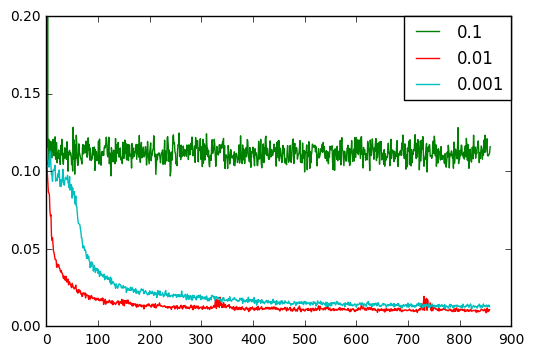

In [14]:
plt.figure(3)
axes = plt.gca()
axes.set_ylim([0,0.2])
for idx in range(len(lr)):
    plt.plot(costCurve[idx], label=str(lr[idx]))
plt.legend(borderaxespad=0.)
plt.show()